# exp038
trans_mapリーク対策2

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [2]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp039"
    seed = 42
    k = 20
    cand_n = 10
    negative_sample = 1
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [3]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, filename))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0


cache = Cache()

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [6]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df[f"{name}_rank"] = new_candidate_df.groupby("session")["session"].cumcount()
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])
        
        self.output = self.output.merge(new_candidate_df, on=["session", "aid"], how="left")

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [7]:
@noglobal(excepts=["cfg", "logger"])
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [8]:
@noglobal(excepts=["cfg", "logger"])
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [9]:
@noglobal(excepts=["cfg", "logger"])
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n * cfg.negative_sample, random_state=cfg.seed)])

In [10]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions, candidate, week):
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id
        self.week = week

    @noglobal(excepts=["cfg", "logger"])
    def add_features(self):
            self._prep()
            self._session_cnt()
            self._session_aid_nunique()
            self._session_last_type()
            # self._session_last_dt()
            self._aid_cnt()
            self._all_times_aid_features()
            # self._session_mean_ts()
            # self._aid_mean_ts()
            # self._aid_cnt_ratio_at_session_last()
            # self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    @noglobal(excepts=["cfg", "logger"])
    def _prep(self):
        logger.info("[features] prep : start")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_cnt(self):
        logger.info("[features] session_cnt : start")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_aid_nunique(self):
        logger.info("[features] session_aid_nunique : start")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_type(self):
        logger.info("[features] session_last_type : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_dt(self):
        logger.info("[features] session_last_dt : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_mean_ts(self):
        logger.info("[features] session_mean_ts : start")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_mean_ts(self):
        logger.info("[features] aid_mean_ts : start")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")
       
    @noglobal(excepts=["cfg", "logger"])
    def _aid_session_nunique(self):
        logger.info("[features] aid_session_unique : start")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    @noglobal(excepts=["cfg", "logger"]) 
    def _aid_cnt_ratio_at_session_last(self):
        logger.info("[features] aid_cnt_ratio_atsession_last : start")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.merge(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas(), on=["aid", f"session_last_{dt_}"], how="left")
            self.output[f"aid_cnt_ratio_at_session_last_{dt_}"] = self.output[f"aid_cnt_ratio_at_session_last_{dt_}"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_cnt(self):
        logger.info("[features] aid_cnt : start")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

    @noglobal(excepts=["cfg", "logger"])
    def _all_times_aid_features(self):
        feats = ["all_times_aid_freq",
                 "all_times_aid_clicks_freq",
                 "all_times_aid_carts_freq",
                 "all_times_aid_orders_freq",
                 "all_times_aid_session_freq",
                 "all_times_aid_session_clicks_freq",
                 "all_times_aid_session_carts_freq",
                 "all_times_aid_session_orders_freq",
                 "all_times_aid_carts_ratio_with_clicks",
                 "all_times_aid_orders_ratio_with_clicks",
                 "all_times_aid_date_std",
                 "all_times_aid_hour_std",
                 "all_times_aid_day_of_week_std"]
        
        for feat in feats:
            if self.week is None:
                with open(cfg.prep_dir + f"{feat}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            else:
                with open(cfg.prep_dir + f"{feat}_{self.week}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            self.output[feat] = self.output["aid"].map(feat_map)


In [11]:
@noglobal(excepts=["cfg", "logger"])
def add_features(sessions, cand_df, week=None):
    feat = Features(sessions, cand_df, week)
    feat.add_features()
    return feat.output

In [12]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions, labels)
    else:
        cand = Candidate(sessions)

    cand.add(strategy="session_frequent", name="session_frequent", k=cfg.cand_n)
    cand.add(strategy="session_latest", name="session_latest", k=cfg.cand_n)
    # cand.add(strategy="total_frequent", name="total_frequent", k=cfg.cand_n)
    cand.add(strategy="session_frequent", trans_map=trans_maps["pair0"], name="session_frequent_pair", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=cfg.cand_n)
    
    cand.add(strategy="session_latest", trans_map=trans_maps["type_wt_pair"], name="session_latest_type_wt_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2carts_pair"], name="session_latest_clicks2carts_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2orders_pair"], name="session_latest_clicks2orders_pair", k=cfg.cand_n)
    if labels is not None:
        return cand.output, cand.results
    else:
        return cand.output

In [13]:
@noglobal(excepts=["cfg", "logger"])
def get_pair_df(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df[pair_df[wt_col] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    return pair_df

@noglobal(excepts=["cfg", "logger"])
def get_pair_dict(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df[pair_df[wt_col] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    return pair_dict

@noglobal(excepts=["cfg", "logger"])
def get_trans_maps(week=None):
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}
    
    pair_df_org = get_pair_df("co_visitation_matrix", "cnt", week)
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict
    
    pair_df_org = get_pair_df("co_visitation_matrix_time_weighted", "wt", week)
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict
    
    trans_maps["clicks_pair"] = get_pair_dict("co_visitation_matrix_clicks", "cnt", week)
    trans_maps["carts_pair"] = get_pair_dict("co_visitation_matrix_carts", "cnt", week)
    trans_maps["orders_pair"] = get_pair_dict("co_visitation_matrix_orders", "cnt", week)
    trans_maps["type_wt_pair"] = get_pair_dict("co_visitation_matrix_type_weighted", "wt", week)
    trans_maps["clicks2carts_pair"] = get_pair_dict("co_visitation_matrix_clicks2carts", "cnt", week)
    trans_maps["clicks2orders_pair"] = get_pair_dict("co_visitation_matrix_clicks2orders", "cnt", week)

    return trans_maps


In [14]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_train_data(type_):
    dfs = []
    for weeks in cfg.train_weeks:
        # データ読み込み
        week_sessions = pd.read_pickle(cfg.prep_dir + f"train_sessions_{weeks}.pkl")
        week_labels = pd.read_pickle(cfg.prep_dir + f"labels_{weeks}.pkl")
        
        cache_file = f"train_cand_{weeks}.pkl"
        cache_path = cache.get_abspath(cache_file)
        print(cache_path)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            cand_df = pd.read_pickle(cache_path)
        else:
            trans_map_cache_file = f"trans_maps_{weeks}.pkl"
            trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
            with open(trans_map_cache_path, "rb") as f:
                trans_maps = pickle.load(f)
            # 候補選出
            cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
            cand_df = reduce_mem_usage(cand_df)
            cand_df.to_pickle(cache_path)

        cand_df = add_labels(cand_df, week_labels, type_)
        cand_df = under_sampling(cand_df, "labels")

        # 特徴量付与
        train_tmp = add_features(week_sessions, cand_df, weeks)
        dfs.append(train_tmp)
        del cand_df, train_tmp
        gc.collect()
        
    train = pd.concat(dfs)
    train = train.reset_index(drop=True)
    train = reduce_mem_usage(train)
    
    return train

In [15]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_valid_cand():
    valid_week = cfg.valid_week
    # データ読み込み
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()
    trans_map_cache_file = f"trans_maps_{valid_week}.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    # validに使うsessionを絞る
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    random.seed(cfg.seed)
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()

    # 候補選出
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    return cand_df, week_sessions, week_labels

In [16]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(cand_df, week_sessions, week_labels, type_):
    # 特徴量付与
    valid = add_features(week_sessions, cand_df, cfg.valid_week)
    valid = add_labels(valid, week_labels, type_)
    valid = valid.reset_index(drop=True)
    valid = reduce_mem_usage(valid)
    return valid

In [17]:
@noglobal(excepts=["cfg", "logger"])
def model_training(train, valid, features, target, valid_labels, type_):
    params = {'objective': 'binary', 
            'boosting': 'gbdt', 
            'learning_rate': 0.1, 
            'metric': 'binary_logloss', 
            'seed': cfg.seed
            }

    # 学習
    vl_pred_df = valid[["session", "aid"]].copy()

    tr_x, tr_y = train[features], train[target]
    vl_x, vl_y = valid[features], valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

    # 特徴量重要度
    fi = pd.DataFrame()
    fi["feature"] = model.feature_name()
    fi["importance"] = model.feature_importance(importance_type="gain")

    # 2値分類の出力を元にk個選定
    vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
    vl_pred_df = vl_pred_df.sort_values(["session", "prob"], ascending=(True, False))
    vl_pred_df = vl_pred_df.groupby(["session"]).head(cfg.k)
    vl_pred_df = vl_pred_df.groupby(["session"])["aid"].apply(list).reset_index()
    
    # 評価
    assert valid_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
    score = evaluate(valid_labels["clicks_labels"].tolist(),
                     valid_labels["carts_labels"].tolist(),
                     valid_labels["orders_labels"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     cfg.k)
    logger.info(f"{type_} valid score")
    logger.info(score)

    # モデル保存
    model.save_model(cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

    # 特徴量重要度
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance({type_})")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance_{type_}.png')

    return score[f"recall_{type_}"]

In [18]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_test_data():
    # testデータ作成
    test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")
    trans_map_cache_file = f"trans_maps.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    dfs =[]
    # 候補選出
    logger.info("[make_test] make_cand_df")
    cand_df = make_cand_df(test_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    # 特徴量付与
    logger.info("[make_test] add_features")
    test = add_features(test_sessions, cand_df)
    test = reduce_mem_usage(test)

    return test

In [19]:
@noglobal(excepts=["cfg", "logger"])
def inference(test, features):
    pred_dfs = []
    for type_ in ["clicks", "carts", "orders"]:
        pred_df_tmp = test[["session", "aid"]].copy()
        # 推論
        model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

        # 2値分類の出力を元にk個選定
        pred_df_tmp["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
        pred_df_tmp = pred_df_tmp.sort_values(["session", "prob"], ascending=(True, False))
        pred_df_tmp = pred_df_tmp.groupby(["session"]).head(cfg.k)
        pred_df_tmp["aid"] = pred_df_tmp["aid"].astype(str)
        pred_df_tmp = pred_df_tmp.groupby(["session"])["aid"].apply(list).reset_index()
        pred_df_tmp["aid"] = pred_df_tmp["aid"].apply(lambda x: ' '.join(x))
        pred_df_tmp["type"] = type_
        pred_dfs.append(pred_df_tmp)
    del test, model
    gc.collect()
    
    pred_df = pd.concat(pred_dfs)
    # sub作成
    sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
    pred_df["session_type"] = pred_df["session"].astype(str) + "_" + pred_df["type"]
    pred_df = pred_df.rename(columns={"aid": "labels"})
    sub = sub.merge(pred_df[["session_type", "labels"]], on="session_type", how="left")
    sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)

In [20]:
@noglobal(excepts=["cfg", "logger", "cache"])
def main():
    scores = {}
    logger.info(f"START")
    line_notify.send(f"{cfg.exp_name} | START")
    
    # trans_map作成
    weeks = [None] + cfg.train_weeks + [cfg.valid_week]
    for week in weeks:
        if week is None:
            cache_file = "trans_maps.pkl"
        else:    
            cache_file = f"trans_maps_{week}.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. load cache and skip process.")
            with open(cache_path, "rb") as f:
                trans_maps = pickle.load(f)
        else:
            trans_maps = get_trans_maps(week)
            with open(cache_path, "wb") as f:
                pickle.dump(trans_maps, f)

    for type_ in ["clicks", "carts", "orders"]:
        # train data作成
        logger.info(f"make {type_}_train_data")
        cache_file = f"{type_}_train.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            train = pd.read_pickle(cache_path)
        else:
            train = make_train_data(type_)
            train.to_pickle(cache_path)
        
        logger.info(f"make {type_}_valid_data")
        # valid cand作成
        cand_cache_path = cache.get_abspath("valid_cand.pkl")
        sessions_cache_path = cache.get_abspath("valid_sessions.pkl")
        labels_cache_path = cache.get_abspath("valid_labels.pkl")
        if cache.exists(cand_cache_path) & cache.exists(labels_cache_path) & cache.exists(sessions_cache_path):
            logger.info("[valid_cand.pkl] cache exists. read cache and skip process.")
            valid_cand = pd.read_pickle(cand_cache_path)
            valid_sessions = pd.read_pickle(sessions_cache_path)
            valid_labels = pd.read_pickle(labels_cache_path)
        else:
            valid_cand, valid_sessions, valid_labels = make_valid_cand()
            valid_cand.to_pickle(cand_cache_path)
            valid_sessions.to_pickle(sessions_cache_path)
            valid_labels.to_pickle(labels_cache_path)

        # valid data作成
        logger.info(f"make {type_}_valid_data")
        cache_file = f"{type_}_valid.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            valid = pd.read_pickle(cache_path)
        else:
            valid = make_valid_data(valid_cand, valid_sessions, valid_labels, type_)
            valid.to_pickle(cache_path)

        # モデル学習
        target = "labels"
        not_use_cols = ["session", "aid", target]
        features = [c for c in train.columns if c not in not_use_cols]

        scores[f"recall_{type_}"] = model_training(train, valid, features, target, valid_labels, type_)

        del train, valid, valid_labels
        gc.collect()
    
    scores["total"] = (float(scores["recall_clicks"]) * 0.1) + (float(scores["recall_carts"]) * 0.3) + (float(scores["recall_orders"]) * 0.6)
    report = f"\n{cfg.exp_name}\n"
    report += f'valid_end\n'
    report += str(scores)
    line_notify.send(report)

    # testデータ
    cache_path = cache.get_abspath("test.pkl")
    if cache.exists(cache_path):
        logger.info("cache exists. read cache and skip process.")
        test = pd.read_pickle(cache_path)
    else:
        test = make_test_data()
        test.to_pickle(cache_path)

    logger.info(f"-------- inference --------")
    inference(test, features)

    line_notify.send(f"{cfg.exp_name} | END!!")

0:00:00.710637 	 START
0:03:28.775039 	 make clicks_train_data


/mnt/otto-recommender-system/output/exp039/cache/train_cand_week3.pkl


0:03:41.099024 	 [make_candidate] session_frequent : start
0:03:42.052718 	 [add_candidate] session_frequent : start
0:03:51.372916 	 [make_candidate] session_latest : start
0:03:52.700946 	 [add_candidate] session_latest : start
0:04:04.407196 	 [make_candidate] session_frequent_pair : start
0:04:05.752607 	 [add_candidate] session_frequent_pair : start
0:04:22.448027 	 [make_candidate] session_latest_pair0 : start
0:04:24.168418 	 [add_candidate] session_latest_pair0 : start
0:04:43.220985 	 [make_candidate] session_latest_pair1 : start
0:04:44.989732 	 [add_candidate] session_latest_pair1 : start
0:05:07.555473 	 [make_candidate] session_latest_pair2 : start
0:05:09.358473 	 [add_candidate] session_latest_pair2 : start
0:05:41.298775 	 [make_candidate] session_latest_pair3 : start
0:05:43.287679 	 [add_candidate] session_latest_pair3 : start
0:06:20.740155 	 [make_candidate] session_latest_pair4 : start
0:06:22.730106 	 [add_candidate] session_latest_pair4 : start
0:07:05.178294 	 [

Memory usage of dataframe is 39366.98 MB
Memory usage after optimization is: 11538.60 MB
Decreased by 70.7%


0:44:57.784431 	 [features] prep : start
0:44:58.085931 	 [features] session_cnt : start
0:45:05.787633 	 [features] session_aid_nunique : start
0:45:07.965756 	 [features] session_last_type : start
0:45:10.495560 	 [features] aid_cnt : start


Memory usage of dataframe is 1089.02 MB
Memory usage after optimization is: 504.99 MB
Decreased by 53.6%


0:46:14.198185 	 make clicks_valid_data
0:46:27.870585 	 [make_candidate] session_frequent : start
0:46:28.124416 	 [add_candidate] session_frequent : start
0:46:28.232329 	 [make_candidate] session_latest : start
0:46:28.477250 	 [add_candidate] session_latest : start
0:46:28.600220 	 [make_candidate] session_frequent_pair : start
0:46:28.947484 	 [add_candidate] session_frequent_pair : start
0:46:29.109186 	 [make_candidate] session_latest_pair0 : start
0:46:29.487242 	 [add_candidate] session_latest_pair0 : start
0:46:29.677430 	 [make_candidate] session_latest_pair1 : start
0:46:30.047499 	 [add_candidate] session_latest_pair1 : start
0:46:30.289363 	 [make_candidate] session_latest_pair2 : start
0:46:30.657516 	 [add_candidate] session_latest_pair2 : start
0:46:30.966955 	 [make_candidate] session_latest_pair3 : start
0:46:31.318654 	 [add_candidate] session_latest_pair3 : start
0:46:31.668033 	 [make_candidate] session_latest_pair4 : start
0:46:32.002056 	 [add_candidate] session

Memory usage of dataframe is 855.87 MB
Memory usage after optimization is: 250.86 MB
Decreased by 70.7%


0:47:09.552637 	 make clicks_valid_data
0:47:09.597669 	 [features] prep : start
0:47:09.609509 	 [features] session_cnt : start
0:47:11.445435 	 [features] session_aid_nunique : start
0:47:11.957887 	 [features] session_last_type : start
0:47:12.550400 	 [features] aid_cnt : start


Memory usage of dataframe is 914.90 MB
Memory usage after optimization is: 416.87 MB
Decreased by 54.4%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 2302250, number of negative: 2302250
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.379856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4278
[LightGBM] [Info] Number of data points in the train set: 4604500, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.398433	valid_1's binary_logloss: 0.38937
[200]	training's binary_logloss: 0.396507	valid_1's binary_logloss: 0.387694
[300]	training's binary_logloss: 0.395367	valid_1's binary_logloss: 0.386879
[400]	training's binary_logloss: 0.394349	valid_1's binary_logloss: 0.386293
[500]	training's binary_logloss: 0.393523	valid_1's binary_logloss: 0.385899
[600]	training's binary_logloss: 0.392755	

0:50:48.660667 	 clicks valid score
0:50:48.662220 	 {'num_clicks': 97136, 'hit_clicks': 46494, 'num_carts': 43211, 'hit_carts': 14312, 'num_orders': 20082, 'hit_orders': 11105, 'recall_clicks': '0.479', 'recall_carts': '0.331', 'recall_orders': '0.553', 'w_recall_clicks': '0.048', 'w_recall_carts': '0.099', 'w_recall_orders': '0.332', 'score': '0.479'}
0:50:49.456378 	 make carts_train_data


/mnt/otto-recommender-system/output/exp039/cache/train_cand_week3.pkl


0:51:00.378042 	 [make_candidate] session_frequent : start
0:51:01.265968 	 [add_candidate] session_frequent : start
0:51:10.336274 	 [make_candidate] session_latest : start
0:51:11.556286 	 [add_candidate] session_latest : start
0:51:22.769662 	 [make_candidate] session_frequent_pair : start
0:51:24.354916 	 [add_candidate] session_frequent_pair : start
0:51:40.916620 	 [make_candidate] session_latest_pair0 : start
0:51:42.637451 	 [add_candidate] session_latest_pair0 : start
0:52:02.905933 	 [make_candidate] session_latest_pair1 : start
0:52:04.598818 	 [add_candidate] session_latest_pair1 : start
0:52:27.997313 	 [make_candidate] session_latest_pair2 : start
0:52:29.640526 	 [add_candidate] session_latest_pair2 : start
0:53:02.673933 	 [make_candidate] session_latest_pair3 : start
0:53:04.603162 	 [add_candidate] session_latest_pair3 : start
0:53:42.731264 	 [make_candidate] session_latest_pair4 : start
0:53:44.664898 	 [add_candidate] session_latest_pair4 : start
0:54:28.139376 	 [

Memory usage of dataframe is 39366.98 MB
Memory usage after optimization is: 11538.60 MB
Decreased by 70.7%


1:33:17.153344 	 [features] prep : start
1:33:17.384337 	 [features] session_cnt : start
1:33:21.704147 	 [features] session_aid_nunique : start
1:33:23.365671 	 [features] session_last_type : start
1:33:25.047981 	 [features] aid_cnt : start


Memory usage of dataframe is 359.37 MB


1:34:35.478874 	 make carts_valid_data


Memory usage after optimization is: 174.88 MB
Decreased by 51.3%


1:34:48.330246 	 [make_candidate] session_frequent : start
1:34:48.570321 	 [add_candidate] session_frequent : start
1:34:48.686988 	 [make_candidate] session_latest : start
1:34:48.930212 	 [add_candidate] session_latest : start
1:34:49.054064 	 [make_candidate] session_frequent_pair : start
1:34:49.410260 	 [add_candidate] session_frequent_pair : start
1:34:49.586682 	 [make_candidate] session_latest_pair0 : start
1:34:49.982644 	 [add_candidate] session_latest_pair0 : start
1:34:50.174090 	 [make_candidate] session_latest_pair1 : start
1:34:50.545627 	 [add_candidate] session_latest_pair1 : start
1:34:50.792439 	 [make_candidate] session_latest_pair2 : start
1:34:51.152974 	 [add_candidate] session_latest_pair2 : start
1:34:51.459717 	 [make_candidate] session_latest_pair3 : start
1:34:51.806282 	 [add_candidate] session_latest_pair3 : start
1:34:52.203331 	 [make_candidate] session_latest_pair4 : start
1:34:52.530314 	 [add_candidate] session_latest_pair4 : start
1:34:53.138790 	 [

Memory usage of dataframe is 855.87 MB
Memory usage after optimization is: 250.86 MB
Decreased by 70.7%


1:35:31.210546 	 make carts_valid_data
1:35:31.256604 	 [features] prep : start
1:35:31.270772 	 [features] session_cnt : start
1:35:35.900522 	 [features] session_aid_nunique : start
1:35:36.408071 	 [features] session_last_type : start
1:35:37.056725 	 [features] aid_cnt : start


Memory usage of dataframe is 929.65 MB
Memory usage after optimization is: 437.27 MB
Decreased by 53.0%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 747672, number of negative: 747672
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4362
[LightGBM] [Info] Number of data points in the train set: 1495344, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.381756	valid_1's binary_logloss: 0.371745
[200]	training's binary_logloss: 0.377388	valid_1's binary_logloss: 0.368528
[300]	training's binary_logloss: 0.375243	valid_1's binary_logloss: 0.367983
[400]	training's binary_logloss: 0.373313	valid_1's binary_logloss: 0.367599
[500]	training's binary_logloss: 0.371547	valid_1's binary_logloss: 0.36741
[600]	training's binary_logloss: 0.369974	va

1:36:56.132224 	 carts valid score
1:36:56.133458 	 {'num_clicks': 97136, 'hit_clicks': 45635, 'num_carts': 43211, 'hit_carts': 14603, 'num_orders': 20082, 'hit_orders': 11324, 'recall_clicks': '0.470', 'recall_carts': '0.338', 'recall_orders': '0.564', 'w_recall_clicks': '0.047', 'w_recall_carts': '0.101', 'w_recall_orders': '0.338', 'score': '0.487'}
1:36:56.792991 	 make orders_train_data


/mnt/otto-recommender-system/output/exp039/cache/train_cand_week3.pkl


1:37:08.192262 	 [make_candidate] session_frequent : start
1:37:09.070826 	 [add_candidate] session_frequent : start
1:37:18.548182 	 [make_candidate] session_latest : start
1:37:19.785701 	 [add_candidate] session_latest : start
1:37:31.634216 	 [make_candidate] session_frequent_pair : start
1:37:33.045540 	 [add_candidate] session_frequent_pair : start
1:37:50.850222 	 [make_candidate] session_latest_pair0 : start
1:37:52.363478 	 [add_candidate] session_latest_pair0 : start
1:38:12.843683 	 [make_candidate] session_latest_pair1 : start
1:38:14.634053 	 [add_candidate] session_latest_pair1 : start
1:38:38.577553 	 [make_candidate] session_latest_pair2 : start
1:38:40.245903 	 [add_candidate] session_latest_pair2 : start
1:39:14.094177 	 [make_candidate] session_latest_pair3 : start
1:39:15.828269 	 [add_candidate] session_latest_pair3 : start
1:39:55.388074 	 [make_candidate] session_latest_pair4 : start
1:39:57.577734 	 [add_candidate] session_latest_pair4 : start
1:40:42.843613 	 [

Memory usage of dataframe is 39366.98 MB
Memory usage after optimization is: 11538.60 MB
Decreased by 70.7%


2:21:40.660101 	 [features] prep : start
2:21:40.891741 	 [features] session_cnt : start
2:21:44.623892 	 [features] session_aid_nunique : start
2:21:46.185795 	 [features] session_last_type : start
2:21:47.760124 	 [features] aid_cnt : start


Memory usage of dataframe is 266.47 MB


2:22:54.137353 	 make orders_valid_data


Memory usage after optimization is: 132.07 MB
Decreased by 50.4%


2:23:06.536605 	 [make_candidate] session_frequent : start
2:23:06.777971 	 [add_candidate] session_frequent : start
2:23:06.904483 	 [make_candidate] session_latest : start
2:23:07.121822 	 [add_candidate] session_latest : start
2:23:07.256950 	 [make_candidate] session_frequent_pair : start
2:23:07.614951 	 [add_candidate] session_frequent_pair : start
2:23:07.795053 	 [make_candidate] session_latest_pair0 : start
2:23:08.198586 	 [add_candidate] session_latest_pair0 : start
2:23:08.412116 	 [make_candidate] session_latest_pair1 : start
2:23:08.781016 	 [add_candidate] session_latest_pair1 : start
2:23:09.037984 	 [make_candidate] session_latest_pair2 : start
2:23:09.407534 	 [add_candidate] session_latest_pair2 : start
2:23:09.734319 	 [make_candidate] session_latest_pair3 : start
2:23:10.104894 	 [add_candidate] session_latest_pair3 : start
2:23:10.548546 	 [make_candidate] session_latest_pair4 : start
2:23:10.889276 	 [add_candidate] session_latest_pair4 : start
2:23:11.551005 	 [

Memory usage of dataframe is 855.87 MB
Memory usage after optimization is: 250.86 MB
Decreased by 70.7%


2:23:50.562739 	 make orders_valid_data
2:23:50.610549 	 [features] prep : start
2:23:50.626223 	 [features] session_cnt : start
2:23:54.673501 	 [features] session_aid_nunique : start
2:23:55.221553 	 [features] session_last_type : start
2:23:55.838801 	 [features] aid_cnt : start


Memory usage of dataframe is 929.65 MB
Memory usage after optimization is: 437.27 MB
Decreased by 53.0%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 554397, number of negative: 554397
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 1108794, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.23625	valid_1's binary_logloss: 0.222393
[200]	training's binary_logloss: 0.232064	valid_1's binary_logloss: 0.220857
[300]	training's binary_logloss: 0.229523	valid_1's binary_logloss: 0.220643
[400]	training's binary_logloss: 0.227356	valid_1's binary_logloss: 0.220531
[500]	training's binary_logloss: 0.225339	valid_1's binary_logloss: 0.220522
Early stopping, best iteration is:
[472]	tra

2:24:54.838093 	 orders valid score
2:24:54.839379 	 {'num_clicks': 97136, 'hit_clicks': 44484, 'num_carts': 43211, 'hit_carts': 14261, 'num_orders': 20082, 'hit_orders': 11349, 'recall_clicks': '0.458', 'recall_carts': '0.330', 'recall_orders': '0.565', 'w_recall_clicks': '0.046', 'w_recall_carts': '0.099', 'w_recall_orders': '0.339', 'score': '0.484'}
2:25:01.890766 	 [make_test] make_cand_df
2:25:02.268492 	 [make_candidate] session_frequent : start
2:25:02.811509 	 [add_candidate] session_frequent : start
2:25:04.916604 	 [make_candidate] session_latest : start
2:25:05.417589 	 [add_candidate] session_latest : start
2:25:08.011352 	 [make_candidate] session_frequent_pair : start
2:25:08.661537 	 [add_candidate] session_frequent_pair : start
2:25:12.581216 	 [make_candidate] session_latest_pair0 : start
2:25:13.406297 	 [add_candidate] session_latest_pair0 : start
2:25:17.857669 	 [make_candidate] session_latest_pair1 : start
2:25:18.608164 	 [add_candidate] session_latest_pair1 : s

Memory usage of dataframe is 11699.91 MB


2:34:57.210977 	 [make_test] add_features


Memory usage after optimization is: 3429.28 MB
Decreased by 70.7%


2:34:57.558667 	 [features] prep : start
2:34:57.651888 	 [features] session_cnt : start
2:35:32.603715 	 [features] session_aid_nunique : start
2:35:42.304354 	 [features] session_last_type : start
2:35:52.351817 	 [features] aid_cnt : start


Memory usage of dataframe is 12506.80 MB
Memory usage after optimization is: 6202.97 MB
Decreased by 50.4%


2:38:33.346563 	 -------- inference --------


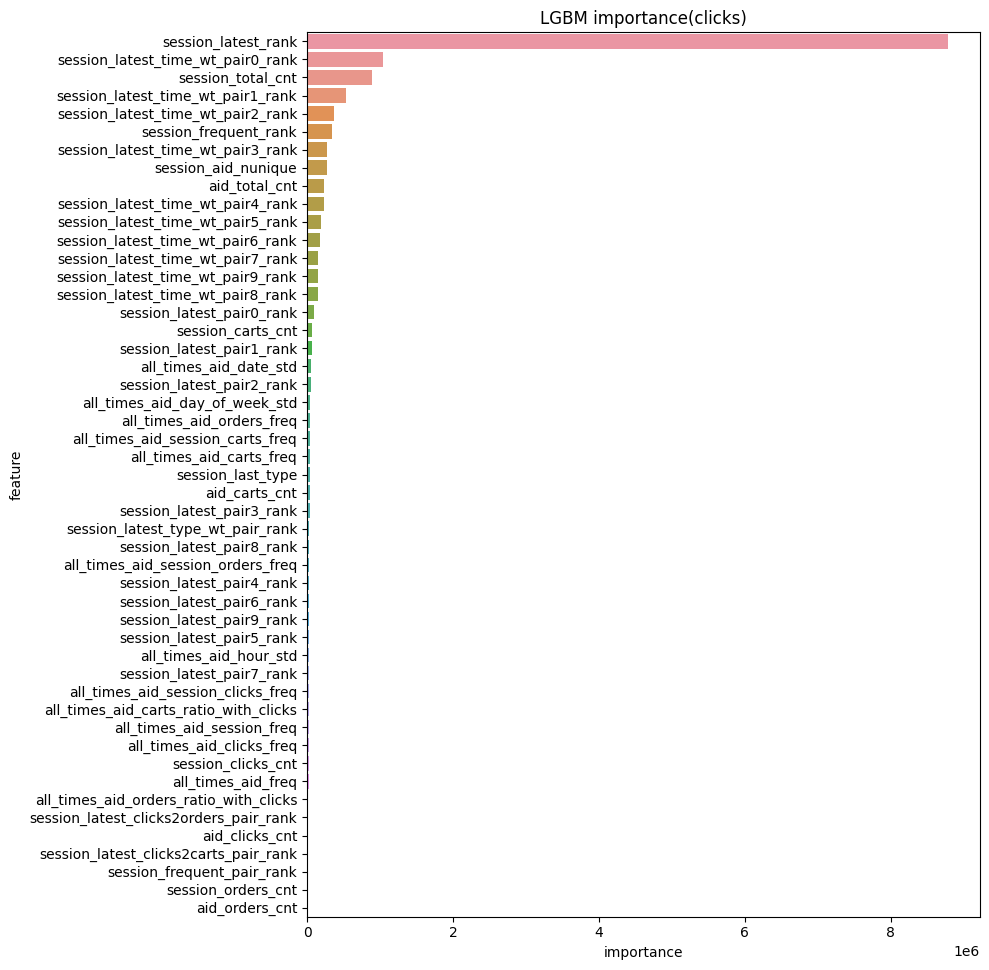

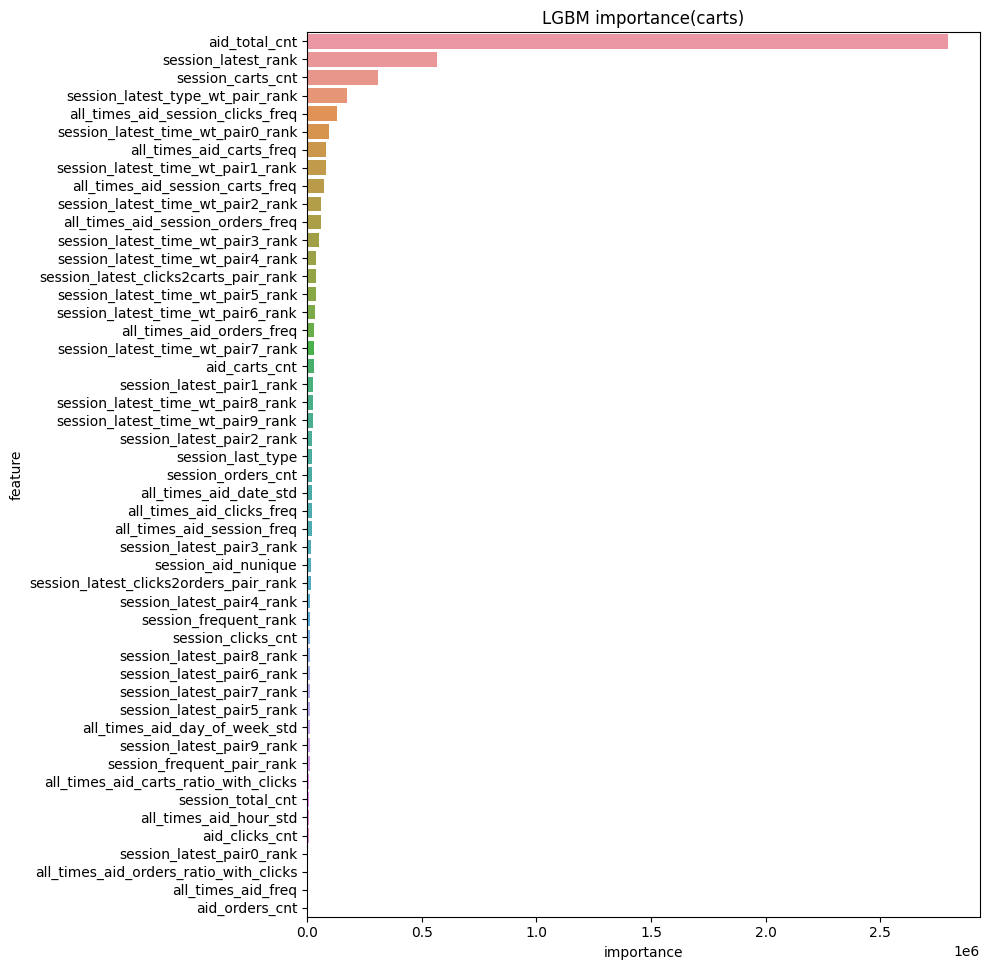

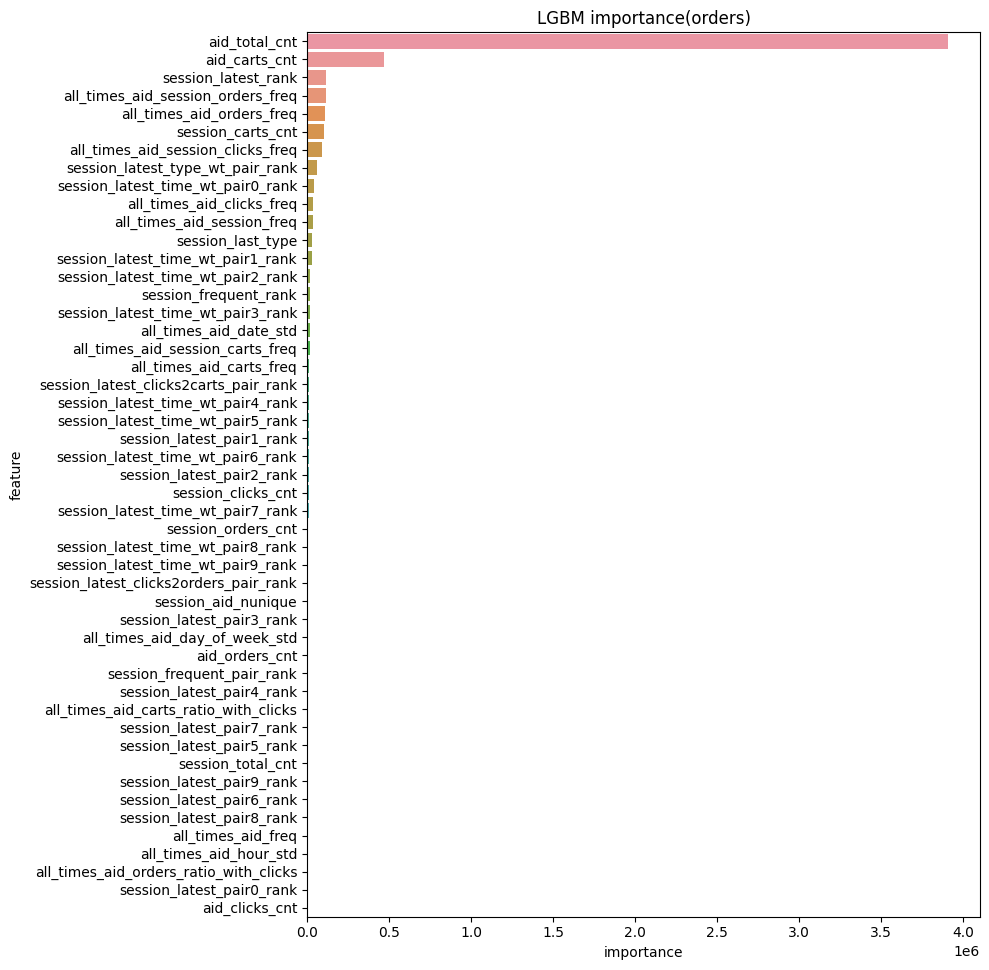

In [21]:
try:
    main()
except Exception as e:
    logger.error(traceback.format_exc())
    line_notify.send(f"{cfg.exp_name} | ERROR!!\n{traceback.format_exc()}")